# Mumbai house price prediction model

Mumbai has the most valuable real estate market in India. Owning an apartment in Mumbai is a feat. We will create a model to predict the price of an apartment in Mumbai!

We will use the Simple Linear Regressor and Random Forest Regressor classes in scikit-learn to help us with building our model.

In [42]:
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt
import seaborn as sns

Read the dataset

In [43]:
df = pd.read_csv("Mumbai1.csv")
df.head()

,Price,Area,Location,No. of Bedrooms,New/Resale,Gymnasium,Lift Available,Car Parking,Maintenance Staff,24x7 Security,Children's Play Area,Clubhouse,Intercom,Landscaped Gardens,Indoor Games,Gas Connection,Jogging Track,Swimming Pool
0,4850000,720,Kharghar,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0
1,4500000,600,Kharghar,1,0,1,1,1,1,1,0,1,0,0,0,0,1,1
2,6700000,650,Kharghar,1,0,1,1,1,1,1,1,1,1,0,0,0,1,1
3,4500000,650,Kharghar,1,0,0,1,1,1,1,0,0,1,1,0,0,0,0
4,5000000,665,Kharghar,1,0,0,1,1,1,1,0,0,1,1,0,0,0,0


## Remove unnecessary columns

The New/Resale column is not important for this model and we can drop it

In [44]:
df_1 = df.drop(['New/Resale'], axis='columns')
df_1.head()

,Price,Area,Location,No. of Bedrooms,Gymnasium,Lift Available,Car Parking,Maintenance Staff,24x7 Security,Children's Play Area,Clubhouse,Intercom,Landscaped Gardens,Indoor Games,Gas Connection,Jogging Track,Swimming Pool
0,4850000,720,Kharghar,1,0,1,1,1,1,0,0,0,0,0,0,0,0
1,4500000,600,Kharghar,1,1,1,1,1,1,0,1,0,0,0,0,1,1
2,6700000,650,Kharghar,1,1,1,1,1,1,1,1,1,0,0,0,1,1
3,4500000,650,Kharghar,1,0,1,1,1,1,0,0,1,1,0,0,0,0
4,5000000,665,Kharghar,1,0,1,1,1,1,0,0,1,1,0,0,0,0


Now lets check for null values

In [45]:
df_1.isnull().sum()

Price                   0
Area                    0
Location                0
No. of Bedrooms         0
Gymnasium               0
Lift Available          0
Car Parking             0
Maintenance Staff       0
24x7 Security           0
Children's Play Area    0
Clubhouse               0
Intercom                0
Landscaped Gardens      0
Indoor Games            0
Gas Connection          0
Jogging Track           0
Swimming Pool           0
dtype: int64

No null values, which is good.

# Data Visualization and Feature Engineering

We can make a heat map as follows :

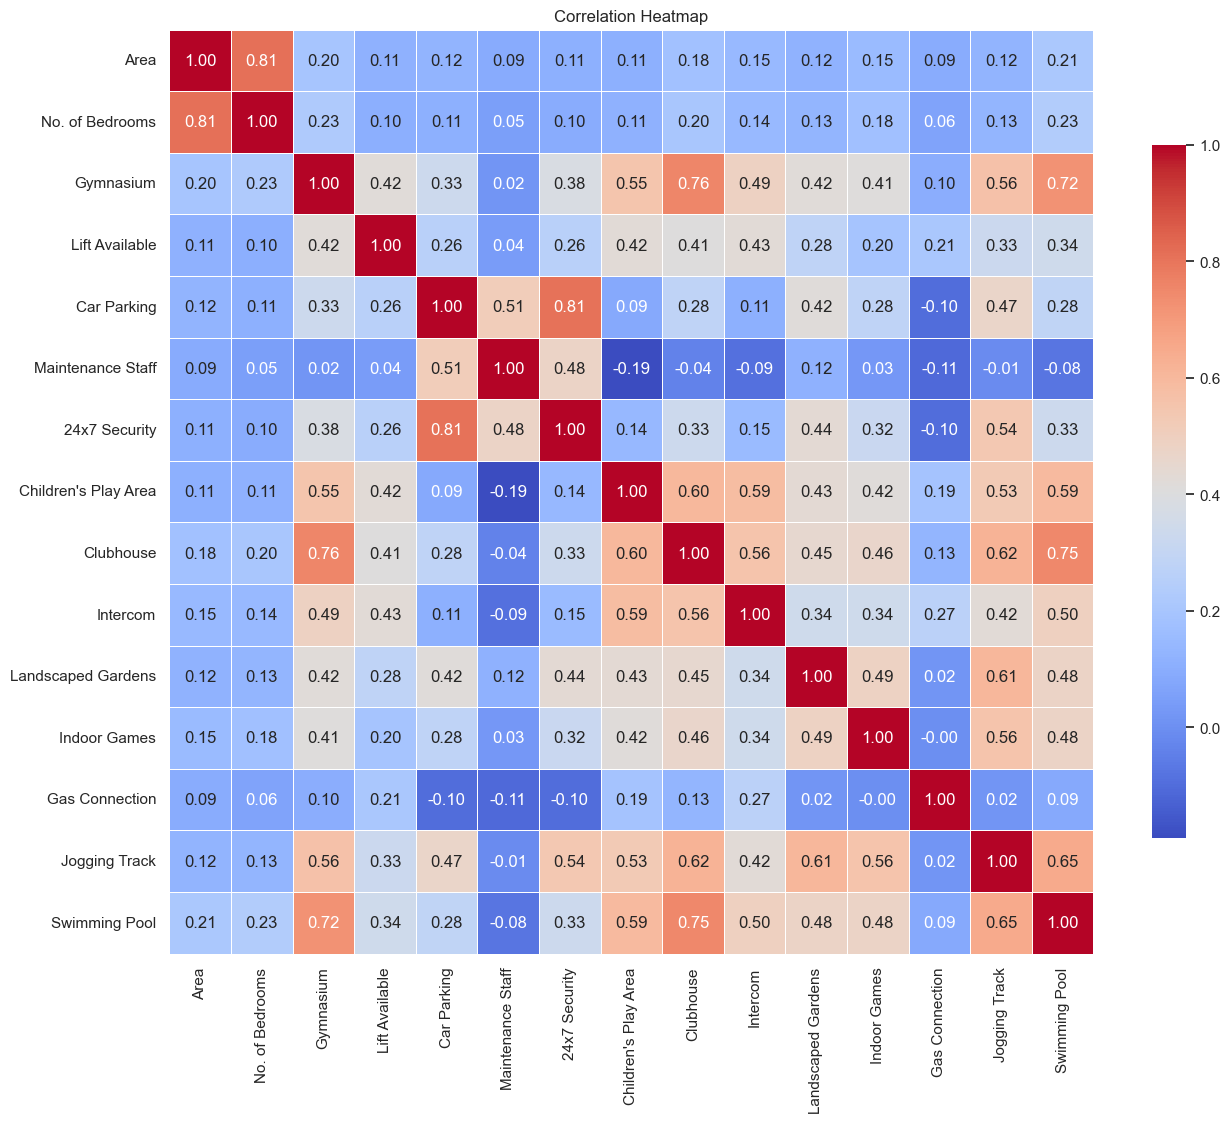

In [46]:
correlation_columns = ['Area', 'No. of Bedrooms', 'Gymnasium', 'Lift Available', 'Car Parking', 'Maintenance Staff', '24x7 Security', "Children's Play Area", 'Clubhouse', 'Intercom', 'Landscaped Gardens', 'Indoor Games', 'Gas Connection', 'Jogging Track', 'Swimming Pool']
correlation_matrix = df_1[correlation_columns].corr()
cool_palette = sns.color_palette("coolwarm", as_cmap=True)
sns.set(style="whitegrid")
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap=cool_palette, fmt=".2f", linewidths=.5, square=True, cbar_kws={"shrink": 0.75})

plt.title('Correlation Heatmap')
plt.show()

From the heatmap, we can infer the following:
1. The variables "Area" and "No. of Bedrooms" have a strong positive correlation of 0.81. 
2. "Gymnasium" has a moderate positive correlation with several features, such as "Children's Play Area" (0.55), "Clubhouse" (0.76), and "Swimming Pool" (0.72). This suggests that there are fancy Apartment complex and societies that offer such ammenities. Mostly at a higher price.
3. Some other moderate positive correlations include "Gymnasium" and "Lift Available" (0.42), "Children's Play Area" and "Clubhouse" (0.60), and "Clubhouse" and "Swimming Pool" (0.75).

Let us visualize two parameters, Number of Bedrooms and Location. 

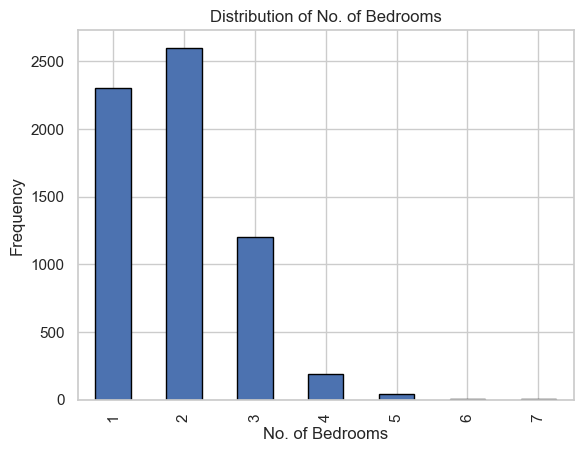

In [47]:
# No. of bedrooms Analysis

unique_bedrooms = df['No. of Bedrooms'].unique()
df_1['No. of Bedrooms'].value_counts().loc[unique_bedrooms].sort_index().plot(kind='bar', edgecolor='black')
plt.xlabel('No. of Bedrooms')
plt.ylabel('Frequency')
plt.title('Distribution of No. of Bedrooms')
plt.show()

In [48]:
df_1['No. of Bedrooms'].value_counts()

No. of Bedrooms
2    2601
1    2307
3    1201
4     190
5      39
6       7
7       2
Name: count, dtype: int64

There are a lot of 1, 2 and 3 Bedroom apartments while 4 Bedrooms and above are very few. Let us group 4 and above together.

In [49]:
df_1['No. of Bedrooms'] = df_1['No. of Bedrooms'].replace({4: '4-7', 5: '4-7', 6: '4-7', 7: '4-7'})
df_1['No. of Bedrooms'].value_counts()

No. of Bedrooms
2      2601
1      2307
3      1201
4-7     238
Name: count, dtype: int64

Now, let us visulize the location column.

In [50]:
location_counts = df_1.Location.value_counts() # The number of entries in our dataset for a particular location (Out of 413 locations)
location_counts.describe()

count    413.000000
mean      15.368039
std       48.351616
min        1.000000
25%        1.000000
50%        2.000000
75%        8.000000
max      533.000000
Name: count, dtype: float64

We can see a lot of locations which have 15 houses or less. Let us group all such locations together and implement Dimensionality reduction (Inspired by Owais Bin Mushtaq https://www.kaggle.com/code/owaisbinmushtaq/housing-price-in-mumbai ).
We can choose either <=15 or <=10 and see which gives a better result.

In [51]:
location_counts = df_1.Location.value_counts()
locations_to_group = location_counts[location_counts <= 10].index
df_1['Location'] = df_1['Location'].replace(locations_to_group, 'Others')
updated_location_counts = df_1['Location'].value_counts()
updated_location_counts

Location
Others            808
Kharghar          533
Thane West        418
Mira Road East    390
Ulwe              319
                 ... 
Vashi              12
matunga east       12
Kalyan East        11
Palghar            11
Kurla West         11
Name: count, Length: 90, dtype: int64

Before visualizing each location, let us create a new column which would contain Price per square feet of the apartment.

In [52]:
df_1['Price_per_sqft'] = df_1['Price'] / df_1['Area']
df_1.head()

,Price,Area,Location,No. of Bedrooms,Gymnasium,Lift Available,Car Parking,Maintenance Staff,24x7 Security,Children's Play Area,Clubhouse,Intercom,Landscaped Gardens,Indoor Games,Gas Connection,Jogging Track,Swimming Pool,Price_per_sqft
0,4850000,720,Kharghar,1,0,1,1,1,1,0,0,0,0,0,0,0,0,6736.111111
1,4500000,600,Kharghar,1,1,1,1,1,1,0,1,0,0,0,0,1,1,7500.000000
2,6700000,650,Kharghar,1,1,1,1,1,1,1,1,1,0,0,0,1,1,10307.692308
3,4500000,650,Kharghar,1,0,1,1,1,1,0,0,1,1,0,0,0,0,6923.076923
4,5000000,665,Kharghar,1,0,1,1,1,1,0,0,1,1,0,0,0,0,7518.796992


Now that 'Price_per_sqft' has been appended to the dataset, let us visulaize each location, especially the others column and look for outliers in terms of Price per square feet.

In [53]:
# Filter the data for 'Price_per_sqft' and 'Location'
data_for_boxplot = df_1[['Price_per_sqft', 'Location']]

# Get unique locations
unique_locations = df_1['Location'].unique()

# Create subplots for each location
fig, axes = plt.subplots(nrows=len(unique_locations), figsize=(16, 5 * len(unique_locations)))

# Iterate through unique locations and create box plots
for i, location in enumerate(unique_locations):
    sns.boxplot(x='Price_per_sqft', data=data_for_boxplot[data_for_boxplot['Location'] == location], ax=axes[i])
    axes[i].set_title(f'Box Plot for {location}')
    axes[i].set_xlabel('Price_per_sqft')

plt.tight_layout()
plt.show()

Let us drop some of the extreme outliers

In [54]:
grouped_data = df_1.groupby('Location')

def remove_outliers(group):
    Q1 = group['Price_per_sqft'].quantile(0.25)
    Q3 = group['Price_per_sqft'].quantile(0.75)
    IQR = Q3 - Q1

    # Define a threshold for identifying outliers
    outlier_threshold = 1.5

    # Identify potential outliers
    outliers_mask = (group['Price_per_sqft'] < (Q1 - outlier_threshold * IQR)) | (group['Price_per_sqft'] > (Q3 + outlier_threshold * IQR))

    # Remove outliers
    return group[~outliers_mask]

# Apply the function to each group
df_2 = grouped_data.apply(remove_outliers)

# Reset index after removing outliers
df_2.reset_index(drop=True, inplace=True)
df_2.shape

(5983, 18)

In [55]:
df_2.head()

,Price,Area,Location,No. of Bedrooms,Gymnasium,Lift Available,Car Parking,Maintenance Staff,24x7 Security,Children's Play Area,Clubhouse,Intercom,Landscaped Gardens,Indoor Games,Gas Connection,Jogging Track,Swimming Pool,Price_per_sqft
0,9500000,1000,Airoli,2,0,1,1,1,1,0,1,0,0,0,0,0,1,9500.000000
1,14900000,1245,Airoli,2,0,1,1,0,0,0,0,0,0,0,1,0,0,11967.871486
2,14000000,1183,Airoli,2,1,1,1,0,1,1,1,1,1,1,0,1,1,11834.319527
3,14800000,1245,Airoli,2,0,1,1,1,1,0,0,0,0,0,0,0,0,11887.550201
4,6400000,495,Airoli,1,0,0,0,0,0,0,0,0,0,0,0,0,0,12929.292929


After removing the extreme outliers, we are left with 5983 rows of data.

# Encoding
After Feature engineering, we can use One Hort Encoding on 'Location' and 'No. of Bedrooms'.

In [56]:
df_2.columns

Index(['Price', 'Area', 'Location', 'No. of Bedrooms', 'Gymnasium',
       'Lift Available', 'Car Parking', 'Maintenance Staff', '24x7 Security',
       'Children's Play Area', 'Clubhouse', 'Intercom', 'Landscaped Gardens',
       'Indoor Games', 'Gas Connection', 'Jogging Track', 'Swimming Pool',
       'Price_per_sqft'],
      dtype='object')

In [57]:
df_2 = pd.get_dummies(df_1, columns=['No. of Bedrooms', 'Location'], prefix=['Bedrooms', 'Location'])
df_2.head()

,Price,Area,Gymnasium,Lift Available,Car Parking,Maintenance Staff,24x7 Security,Children's Play Area,Clubhouse,Intercom,...,Location_Vashi,Location_Ville Parle East,Location_Virar,Location_Virar East,Location_Virar West,Location_Wadala,Location_Wadala East Wadala,Location_Worli,Location_matunga east,Location_mumbai
0,4850000,720,0,1,1,1,1,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,4500000,600,1,1,1,1,1,0,1,0,...,False,False,False,False,False,False,False,False,False,False
2,6700000,650,1,1,1,1,1,1,1,1,...,False,False,False,False,False,False,False,False,False,False
3,4500000,650,0,1,1,1,1,0,0,1,...,False,False,False,False,False,False,False,False,False,False
4,5000000,665,0,1,1,1,1,0,0,1,...,False,False,False,False,False,False,False,False,False,False


# Split dependent and independent variables.

In [58]:
X = df_2.drop(['Price'],axis = 'columns')
y = df_2.Price

# Create Training, Testing and Validation sets.


In [59]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [60]:
X_train.shape

(3808, 109)

In [61]:
X_test.shape

(1270, 109)

In [62]:
X_val.shape

(1269, 109)

# Simple Linear Regression.
Let us first apply the SLR model

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

Let us perform cross-validation using K-fold

In [64]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr_cross_val_scores = cross_val_score(lr_model, X_train, y_train, scoring='r2', cv=kf)
print('Simple Linear Regression Cross-Validation R2 Scores:', lr_cross_val_scores)
print('Mean R2 Score:', np.mean(lr_cross_val_scores))

Simple Linear Regression Cross-Validation R2 Scores: [0.86596208 0.87375961 0.93170945 0.8669874  0.85653492]
Mean R2 Score: 0.8789906907790772


Let us check for overfitting by calculating R2 score for the Validation set.

In [65]:
y_pred_lin_val = lr_model.predict(X_val)
r2_lin_val = r2_score(y_val, y_pred_lin_val)
print('\nSimple Linear Regression Metrics on Validation Set:')
print(f'R-squared (R2): {r2_lin_val}')


Simple Linear Regression Metrics on Validation Set:
R-squared (R2): 0.8497217623395956


Lower R2 score for the validation set than the Cross validation score indicates slight over-fitting. Let us calculate Metrics of the Simple Linear Regression model.

In [66]:
y_pred_lin = lr_model.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
mae_lin = mean_absolute_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)
print(f'Linear Regression Mean Squared Error (MSE): {mse_lin}')
print(f'Linear Regression Mean Absolute Error: {mae_lin}')
print(f'Linear Regression R-squared (R2): {r2_lin}')

Linear Regression Mean Squared Error (MSE): 36511350691492.5
Linear Regression Mean Absolute Error: 3609234.853543307
Linear Regression R-squared (R2): 0.871492182060797


Actual Price vs Predicted Price (validation set) scatter plot

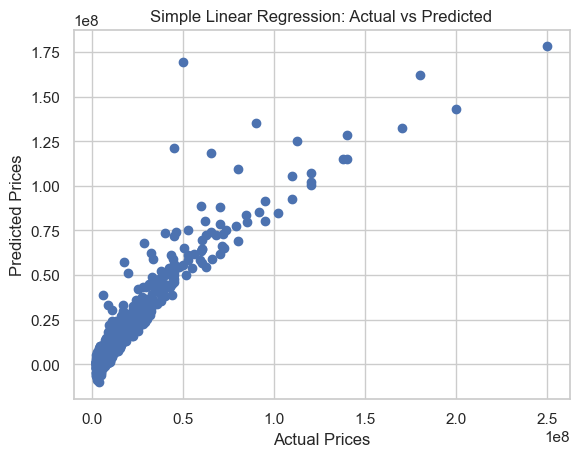

In [67]:
plt.scatter(y_val, y_pred_lin_val)
plt.title('Simple Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

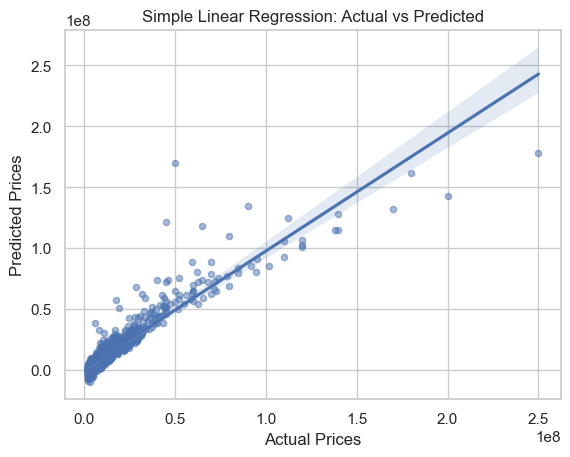

In [68]:
sns.regplot(x=y_val, y=y_pred_lin_val, scatter_kws={'s': 20, 'alpha': 0.5})
plt.title('Simple Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

Actual Price vs Predicted Price (test set) scatter plot

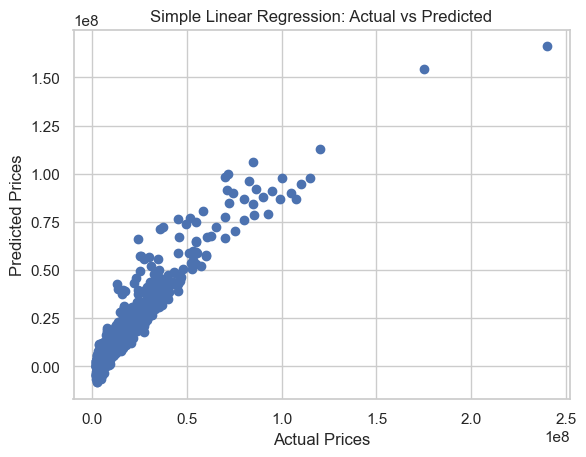

In [69]:
plt.scatter(y_test, y_pred_lin)
plt.title('Simple Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

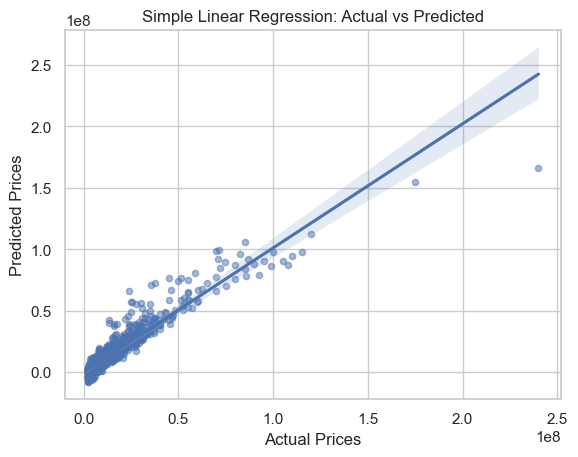

In [70]:
sns.regplot(x=y_test, y=y_pred_lin, scatter_kws={'s': 20, 'alpha': 0.5})
plt.title('Simple Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

# Random Forest Regression

The Simple Linear Regression model gives us a R2 score of 87%. Let's try building a model using the Random Forest Regressor Algorithm.

In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

rf_model = RandomForestRegressor(random_state=10)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=10)

Let's now perform cross-validation and checke the R2 score.

In [72]:
rf_cross_val_scores = cross_val_score(rf_model, X, y, scoring='r2', cv=kf)
print(f'Random Forest Cross-Validation R2 Scores: {rf_cross_val_scores}')
print(f'Mean R2 Score: {np.mean(rf_cross_val_scores)}')

Random Forest Cross-Validation R2 Scores: [0.98307684 0.98372275 0.90418589 0.97365565 0.93294265]
Mean R2 Score: 0.9555167546878437


Now lets calculate the Validation set's R2 score so as to check for over-fitting

In [73]:
y_pred_rf_val = rf_model.predict(X_val)
r2_rf_val = r2_score(y_val, y_pred_rf_val)
print('\nRandom Forest Metrics on Validation Set:')
print(f'R-squared (R2): {r2_rf_val}')


Random Forest Metrics on Validation Set:
R-squared (R2): 0.9833887264159374


Having high R2 scores on both training and validation sets suggests that the Random Forest model is capturing the underlying patterns in the data effectively and is not overfitting. However, there can be more things like comparing MSE and MAE of Training and Validation sets can be done to confirm wheather or not overfitting is occuring in this model.

Let's check metrics of our Random Forest Regression model.

In [74]:
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 6557697203873.586
Mean Absolute Error: 359370.1392047244
R-squared (R2): 0.9769190856428062


Random Forest model scatter plots for Actual vs Predicted (validation set)

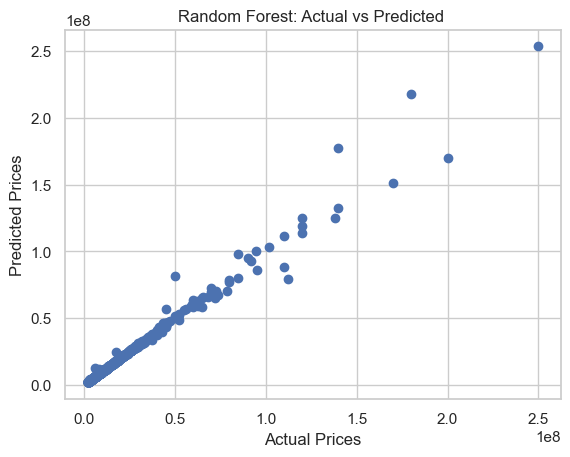

In [75]:
plt.scatter(y_val, y_pred_rf_val)
plt.title('Random Forest: Actual vs Predicted ')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

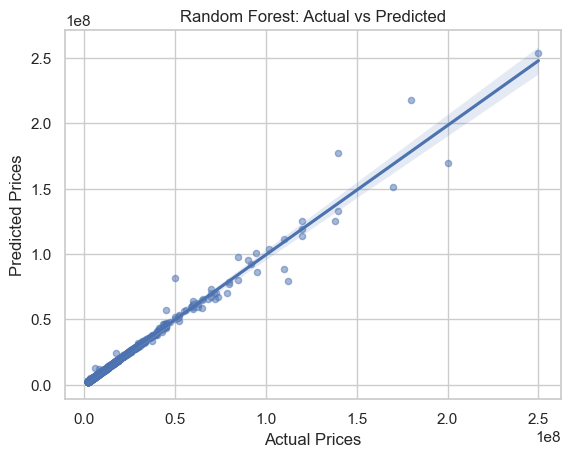

In [76]:
sns.regplot(x=y_val, y=y_pred_rf_val, scatter_kws={'s': 20, 'alpha': 0.5})
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

Random Forestplots for Actual vs Predicted (test set)

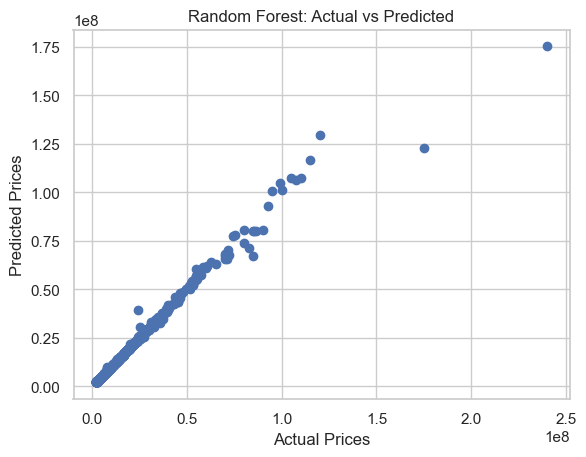

In [77]:
plt.scatter(y_test, y_pred)
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

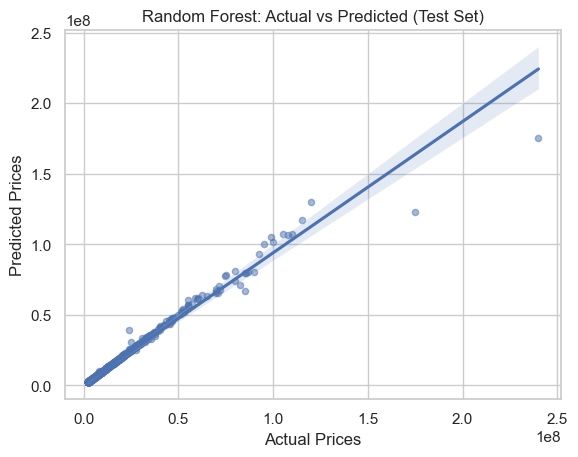

In [78]:
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha': 0.5})
plt.title('Random Forest: Actual vs Predicted (Test Set)')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()